# Project - Large Code Summarization

### Data Pipeline

In [2]:
!pip install datasets


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from datasets import load_dataset
import pandas as pd
import requests
import re
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [12]:
# Load the CodeSearchNet dataset (you can change the split as per your need)
ds = load_dataset("code_search_net", 'python', split='test', trust_remote_code=True)
df = ds.to_pandas()

In [14]:
#print(dataset)
print(df.head())

   repository_name                func_path_in_repository  \
0  soimort/you-get      src/you_get/extractors/youtube.py   
1  soimort/you-get       src/you_get/extractors/miomio.py   
2  soimort/you-get     src/you_get/extractors/fc2video.py   
3  soimort/you-get     src/you_get/extractors/fc2video.py   
4  soimort/you-get  src/you_get/extractors/dailymotion.py   

                  func_name  \
0  YouTube.get_vid_from_url   
1      sina_xml_to_url_list   
2                  makeMimi   
3         fc2video_download   
4      dailymotion_download   

                                   whole_func_string language  \
0  def get_vid_from_url(url):\n        """Extract...   python   
1  def sina_xml_to_url_list(xml_data):\n    """st...   python   
2  def makeMimi(upid):\n    """From http://cdn37....   python   
3  def fc2video_download(url, output_dir = '.', m...   python   
4  def dailymotion_download(url, output_dir='.', ...   python   

                                    func_code_string  \

In [15]:
# Clean docstring
def extract_summary(docstring):
    patterns_to_remove = [
        r':param.*$', r':return.*$', r':type.*$', r':rtype.*$', r'Args:.*$', r'Parameters.*$', r'>>>.*$', 
        r'\* .*$', r'The return type is.*$', r'https?://.*$', r':?Examples?.*$', r'Returns.*$', r'\.\.\.?.*$', 
        r'NOTE.*', r'See Also.*$', r'Links.*$', r'Raises.*$', r'\s\w+:.*$',
    ]
    pattern = re.compile(r'({})'.format('|'.join(patterns_to_remove)), re.MULTILINE | re.DOTALL)
    summary = pattern.sub('', docstring).strip()
    return re.sub('\s+', ' ', summary)

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ayush\AppData\Local\Temp\ipykernel_101332\1294899574.py:10: SyntaxWarning: invalid escape sequence '\s'
  return re.sub('\s+', ' ', summary)


In [17]:
print(df.columns)

Index(['repository_name', 'func_path_in_repository', 'func_name',
       'whole_func_string', 'language', 'func_code_string', 'func_code_tokens',
       'func_documentation_string', 'func_documentation_tokens', 'split_name',
       'func_code_url'],
      dtype='object')


In [20]:
from tqdm import tqdm
tqdm.pandas() 
# Apply docstring cleaning
df['method_summary'] = df['func_documentation_string'].progress_apply(extract_summary)

100%|██████████| 22176/22176 [00:00<00:00, 98147.06it/s]


In [22]:
filtered_df = df[(10 < df['method_summary'].str.len()) & (df['method_summary'].str.len() < 200)]
print(filtered_df.shape)

(18633, 12)


In [25]:
grouped_df = filtered_df.groupby('repository_name')['method_summary'].count().reset_index(name='count')
grouped_df = grouped_df[grouped_df['count'] > 50]

In [27]:
best_repos = list(grouped_df['repository_name'])
selected_df = filtered_df[filtered_df['repository_name'].isin(best_repos)]

In [28]:
# Remove docstrings and comments from code
def remove_docstrings(code):
    docstrings = re.findall(r"'''(.*?)'''", code, re.DOTALL) + re.findall(r'"""(.*?)"""', code, re.DOTALL)
    for docstring in docstrings:
        code = code.replace(docstring, '')
    return code

In [29]:
def remove_comments(code):
    pattern = r"(\".*?\"|\'.*?\')|(#[^\r\n]*$)"
    regex = re.compile(pattern, re.MULTILINE | re.DOTALL)
    def _replacer(match):
        if match.group(2) is not None:
            return ""  # remove comment
        return match.group(1)  # keep string
    return regex.sub(_replacer, code)

In [31]:
print(selected_df.columns)

Index(['repository_name', 'func_path_in_repository', 'func_name',
       'whole_func_string', 'language', 'func_code_string', 'func_code_tokens',
       'func_documentation_string', 'func_documentation_tokens', 'split_name',
       'func_code_url', 'method_summary'],
      dtype='object')


In [32]:
# Apply removal of docstrings and comments
selected_df['method_code'] = selected_df['func_code_string'].apply(remove_docstrings)
selected_df['method_code'] = selected_df['method_code'].apply(remove_comments)

C:\Users\ayush\AppData\Local\Temp\ipykernel_101332\3615263855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['method_code'] = selected_df['func_code_string'].apply(remove_docstrings)
C:\Users\ayush\AppData\Local\Temp\ipykernel_101332\3615263855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['method_code'] = selected_df['method_code'].apply(remove_comments)


In [34]:
final_df = selected_df[['repository_name', 'func_name', 'method_code', 'method_summary', 'whole_func_string', 'func_code_url']]
final_df = final_df.rename(columns={
    'repository_name': 'repo_name', 
    'func_name': 'method_name', 
    'whole_func_string': 'original_method_code', 
    'func_code_url': 'method_path'
}).reset_index(drop=True)

In [35]:
# Split into few-shot and evaluation datasets
fewshot_df = final_df.groupby('repo_name').head(10).reset_index(drop=True)
eval_df = final_df[~final_df.index.isin(fewshot_df.index)]

In [39]:
# Save to JSONL files
DATA_DIR = Path('data/preprocessed')
eval_df.to_json(DATA_DIR / 'method-level-mcsn.jsonl', orient='records', lines=True)
fewshot_df.to_json(DATA_DIR / 'method-level-mcsn-few-shot.jsonl', orient='records', lines=True)

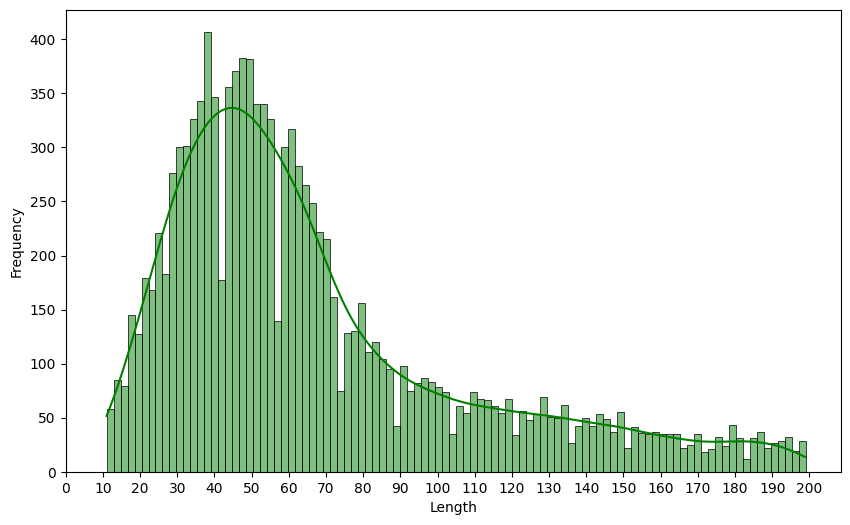

In [40]:
# EDA: Distribution of method summary lengths
tdf = final_df.copy()
tdf['method_summary_length'] = tdf['method_summary'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(data=tdf, x='method_summary_length', bins=100, kde=True, color='green')
plt.xlabel('Length')
plt.xticks(np.arange(0, 210, 10))
plt.ylabel('Frequency')
plt.show()